<p style="text-align:right;">Mario Stanke, University of Greifswald, Germany</p>

# Solution to Exercise Set 4, Exercise 1, Fool a CNN 
In this notebook you will *fool* a neural network by creating an image that looks like a **cat** *to a human beholder* but the neural network predicts a probability of almost 1 that the image is of a **plant**.

Start by executing the whole notebook. Then understand what it does and fill in YOUR CODE where it says HERE.

In [1]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

2024-03-12 20:54:30.999881: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-12 20:54:31.001022: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-12 20:54:31.020972: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-12 20:54:31.020989: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-12 20:54:31.021008: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

### The species names

In [2]:
classnames = ['cat', 'shepherd', 'wolf', 'CommonWheat', 'Maize', 'Small-floweredCranesbill', 'Charlock',
              'FatHen', 'ScentlessMayweed', 'SugarBeet', 'CommonChickweed', 'LooseSilky-bent']

K = 12
name2class = dict(zip(classnames, range(K))) # dictionary that maps a name to its index in classnames array
print("names and classes:", name2class)

names and classes: {'cat': 0, 'shepherd': 1, 'wolf': 2, 'CommonWheat': 3, 'Maize': 4, 'Small-floweredCranesbill': 5, 'Charlock': 6, 'FatHen': 7, 'ScentlessMayweed': 8, 'SugarBeet': 9, 'CommonChickweed': 10, 'LooseSilky-bent': 11}


## Starting Image for Deception


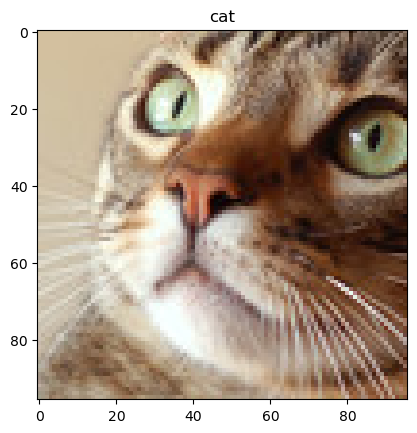

In [3]:
# the image to classify shall look like this image - feel free to change this
img_path = '../data/cats-dogs-plants/cat/11.png'
orig_class = 0
orig_name = classnames[orig_class]

orig_img = cv2.imread(img_path)
orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB) # cv2 has color order BGR rather than RGB
plt.imshow(orig_img)

plt.title(orig_name);

## Load a Pretrained Image Classification CNN

In [4]:
# load the model from the drive
frozen_model = tf.keras.models.load_model('animals_and_plants-frozen.h5')
frozen_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 96, 96, 3)         12        
 Normalization)                                                  
                                                                 
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 92, 32)        9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 45, 45, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 45, 45, 32)        0

2024-03-12 20:54:32.332519: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 20:54:32.332919: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


### Get predictions for the original image
... to verify that the photo is indeed classified as cat.

In [5]:
# make a tensorflow version of the image: scaled to [0,1] and with the extra dimension for the batch
x_ = tf.cast(tf.expand_dims(orig_img, 0), tf.float32) / 255. 

# create a tensorflow variable with respect to which we can differentiatiate
x = tf.Variable(x_) # initialize x iwith the original image

# get the vector of predicted probabilities for the original image
orig_y = frozen_model(x).numpy().squeeze()

In [6]:
orig_pred_class = orig_y.argmax()
orig_pred_prob = orig_y.max()
print("Probabilities that original image belongs to each of the classes:\n", orig_y)
print("Most likely class is ", orig_pred_class, " = ", classnames[orig_pred_class], " with probability", orig_pred_prob)

Probabilities that original image belongs to each of the classes:
 [9.6723628e-01 4.2188838e-03 2.8528327e-02 8.3274398e-07 5.6366948e-06
 9.8628016e-07 3.1146445e-08 1.9396234e-06 1.2231284e-07 3.1174472e-06
 4.3230298e-07 3.4202367e-06]
Most likely class is  0  =  cat  with probability 0.9672363


So far so good. This just confirms that the loaded model predicts the correct class from this particular cat photo with great confidence. All plant classes are very unlikely.
## Pose the Deception of ```frozen_model``` as an Optimization Problem

In [7]:
target_class = 4 # the modified image should be identified as Maize

In [8]:
def target_fkt(x):
    """ The target function to be maximized: The probability of the target class."""
    y = frozen_model(x)
    y = tf.squeeze(y) # remove dimensions of size 1
    target_prob = y[target_class]
    return target_prob

In [9]:
# try the target function on x, which is currently the original image, but will be changed below.
target_fkt(x)

<tf.Tensor: shape=(), dtype=float32, numpy=5.636695e-06>

$x$ is far from being identified as Maize, yet.

### Gradient-based image manipulation
There are several possibilities to change the original image. I suggest the following approach with the code scaffold below.
 1. Compute the gradient, say ```grad```, of ```target_fkt``` with respect to $x$.
 2. Change $x$ in the direction of grad: $x = x + \alpha \cdot \texttt{grad}$.
 3. At the beginning, i.e. when ```x = orig_img```, the gradient has very small entries as the model is amost certain that the image is not of Maize. To make 
 fast progress, choose in each step an $\alpha$ such that the maximal absolute change of a pixel value is ```max_change```.
 3. Observe that the pixel values should be confined to $[0,1]$. 

*Tips:*
 - [tf.abs](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/math/abs) computes the absolute values
 - [tf.reduce_max](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/math/reduce_max) computes a maximum
 - To prevent a division by ```max_grad = 0```, you can use python function ```max( max_grad, epsilon)``` for some small epsilon.
 - [tf.minimum](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/math/minimum) and [tf.maximum](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/math/maximum) compute elementwise the smaller and larger of two values.

However, another approach using a tensorflow optimizer may work as well.

In [10]:
max_iter = 300
max_change = 0.005     # maximum change per iteration and pixel
close_enough = False
iter = 0

while not close_enough and iter < max_iter:
    ### YOUR CODE HERE to compute the gradient grad of target_fkt(x) with respect to x, ~3 lines
    with tf.GradientTape() as tape:      
        grad = tf.zeros_like(x) # replace this
    ### 
    
    ### YOUR CODE HERE to compute the maximum absolute value of all entries of grad
    max_grad = None
    ###
    
    ### YOUR CODE HERE to compute alpha under above condition
    alpha = 0.
    ###

    if (iter % 10 == 0):
        print("SUITABLE PROGRESS MONITORING VARIABLES HERE")
    
    x.assign(x + alpha * grad)
    ### YOUR CODE HERE to prevent images that are "brighter than white" or "darker than black"
    x.assign(x) # change this
    ###
    
    iter += 1
    if (0 > 0.9999): # replace the 0 with the current value of the target_fkt
        close_enough = True

SUITABLE PROGRESS MONITORING VARIABLES HERE
SUITABLE PROGRESS MONITORING VARIABLES HERE
SUITABLE PROGRESS MONITORING VARIABLES HERE
SUITABLE PROGRESS MONITORING VARIABLES HERE
SUITABLE PROGRESS MONITORING VARIABLES HERE
SUITABLE PROGRESS MONITORING VARIABLES HERE
SUITABLE PROGRESS MONITORING VARIABLES HERE
SUITABLE PROGRESS MONITORING VARIABLES HERE
SUITABLE PROGRESS MONITORING VARIABLES HERE
SUITABLE PROGRESS MONITORING VARIABLES HERE
SUITABLE PROGRESS MONITORING VARIABLES HERE
SUITABLE PROGRESS MONITORING VARIABLES HERE
SUITABLE PROGRESS MONITORING VARIABLES HERE
SUITABLE PROGRESS MONITORING VARIABLES HERE
SUITABLE PROGRESS MONITORING VARIABLES HERE
SUITABLE PROGRESS MONITORING VARIABLES HERE
SUITABLE PROGRESS MONITORING VARIABLES HERE
SUITABLE PROGRESS MONITORING VARIABLES HERE
SUITABLE PROGRESS MONITORING VARIABLES HERE
SUITABLE PROGRESS MONITORING VARIABLES HERE
SUITABLE PROGRESS MONITORING VARIABLES HERE
SUITABLE PROGRESS MONITORING VARIABLES HERE
SUITABLE PROGRESS MONITORING VAR

#### Check whether the optimization succeeded

In [11]:
target_prob = target_fkt(x).numpy()
print("probability of class ", target_class, "is", target_prob)

probability of class  4 is 5.636695e-06


That looks good, but $x$ is not an image in the original format (8 bit grayscale). Will the target probability also be large after we made a real image from $x$?

In [12]:
# scale to [0,255] and cast to uint8 {0, ..., 255} 
x_fool = x.numpy().squeeze() * 255.
x_fool = x_fool.astype(np.uint8)

# backconvert x_fool to the format required by the tensorflow model
x_fool_ = tf.cast(tf.expand_dims(x_fool, 0), tf.float32) / 255.

# get predicted probabilities for the actual fooling image x_fool
y_fool = frozen_model(x_fool_).numpy().squeeze()
y_fool_prob = y_fool[target_class]
print("target probability =", y_fool_prob, "\nAll probabilities\n", y_fool)

target probability = 5.636695e-06 
All probabilities
 [9.6723628e-01 4.2188838e-03 2.8528327e-02 8.3274398e-07 5.6366948e-06
 9.8628016e-07 3.1146445e-08 1.9396234e-06 1.2231284e-07 3.1174472e-06
 4.3230298e-07 3.4202367e-06]


## How much has the image changed?

In [13]:
# maximum and average pixel changes
# first make pixel values floating point numbers again as in uint8 -1 = 255
diff = np.absolute(tf.cast(x_fool, tf.float32) - tf.cast(orig_img, tf.float32))
max_pixel_change = np.max(diff)
avg_pixel_change = np.mean(diff)
print("The maximal total and mean absolute change of a pixel was by", max_pixel_change, "and", avg_pixel_change, ", respectively.")

The maximal total and mean absolute change of a pixel was by 0.0 and 0.0 , respectively.


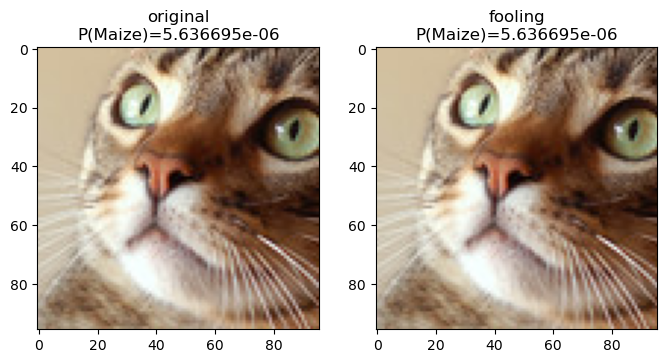

In [14]:
# plot original image and fooling image side by side
_, ax = plt.subplots(1, 2, figsize = (8, 4))
ax[0].imshow(orig_img)
ax[0].set_title("original\nP(" + classnames[target_class] + ")=" + str(orig_y[target_class]));
ax[1].imshow(x_fool)
ax[1].set_title("fooling\nP(" + classnames[target_class] + ")=" + str(y_fool_prob));

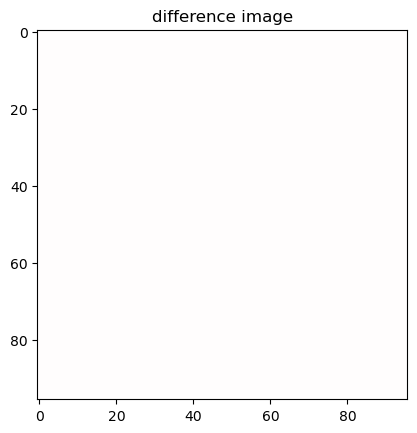

In [15]:
# difference image
diff_img = np.mean((255 + x_fool - orig_img)/2/255, axis = 2) # average over color dimension
plt.imshow(diff_img, vmin = 0., vmax = 1., cmap = plt.get_cmap('seismic')); # < 0.5 is blue, > 0.5 is red
plt.title("difference image");